# Text tonality classification (TF-IDF)
The online store is launching a new service. Now users can edit and enhance product descriptions, similar to wiki communities. In other words, customers can suggest edits and comment on changes made by others. The store needs a tool that can detect toxic comments and flag them for moderation.

Please train a model to classify comments as positive or negative. You have a dataset with annotations indicating the toxicity of the edits.

The goal is to build a model with an F1 quality metric score of at least 0.75.

## Uploading libraries

In [1]:
!pip install xgboost

In [2]:
!pip install catboost

In [3]:
!pip install -Uq spacy

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

## Preparation of data

In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [6]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
df.duplicated().sum()

0

There are no omissions and duplicates.

In [8]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alexander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Let's write a function for lemmatization and clearing of unnecessary characters.

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(text):
    global nlp
    text = (re.sub(r'[^a-z]', ' ', text.lower()))
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [10]:
%%time
tqdm.pandas()
df['lemma_s'] = df['text'].progress_apply(lemmatize)

100%|██████████████████████████████████| 159292/159292 [17:38<00:00, 150.46it/s]

CPU times: user 15min 10s, sys: 8.69 s, total: 15min 19s
Wall time: 17min 38s


Lemmatization was successful.

In [11]:
df.head()

,Unnamed: 0,text,toxic,lemma_s
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m se...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more I can t make any real suggestion on im...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you rememb...


Uploading stop words.

In [12]:
stopwords = list(nltk_stopwords.words('english'))

Let's divide the data frame into training and test samples.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['lemma_s'], df['toxic'], test_size=0.3, 
                                                    shuffle=True, stratify=df['toxic'],random_state=RANDOM_STATE)

In [14]:
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

By applying the value_counts function, we see that we have a strong class imbalance. We will train models by weighing classes with internal methods.

## Building and training models

We will convert the text into TF-IDF vectors within a Pipeline and train different algorithms using built-in methods for class weighting.

### Class weight

#### LogisticRegression

In [20]:
pipeline_lg = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)),
    ]
)
params_lg = {'clf__C': np.logspace(-3,3,7),
            'clf__max_iter': [1000, 1500, 2000, 2500]}
            
grid_lg = GridSearchCV(pipeline_lg, param_grid=params_lg, cv=3, scoring='f1', n_jobs=-1)
grid_lg.fit(X_train, y_train)
best_result_lg = pd.DataFrame(grid_lg.cv_results_).sort_values('rank_test_score').head(1)
best_result_lg = best_result_lg[['mean_fit_time', 'params', 'mean_test_score']]
best_result_lg

,mean_fit_time,params,mean_test_score
19,7.994759,"{'clf__C': 10.0, 'clf__max_iter': 2500}",0.764269


#### RidgeClassifier

In [16]:
pipeline_rd = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", RidgeClassifier(class_weight='balanced', random_state=RANDOM_STATE)),
    ]
)

params_rd = {'clf__alpha': range(1, 10)}

grid_rd = GridSearchCV(pipeline_rd, param_grid=params_rd, cv=3, scoring='f1', n_jobs=-1)
grid_rd.fit(X_train, y_train)
best_result_rd = pd.DataFrame(grid_rd.cv_results_).sort_values('rank_test_score').head(1)
best_result_rd = best_result_rd[['mean_fit_time', 'params', 'mean_test_score']]
best_result_rd

,mean_fit_time,params,mean_test_score
8,2.153194,{'clf__alpha': 9},0.710685


#### SVC

In [21]:
pipeline_svc = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", SVC(class_weight='balanced', random_state=RANDOM_STATE)),
    ]
)
params_svc = {'clf__C': [0.1, 1, 10, 100],
              'clf__gamma': [ 1, 0.1, 0.01, 0.001],
              'clf__kernel': ['rbf', 'poly', 'sigmoid']}
grid_svc = GridSearchCV(pipeline_svc, param_grid=params_svc, cv=3,  scoring='f1', n_jobs=-1)

grid_svc.fit(X_train, y_train)
best_result_svc = pd.DataFrame(grid_svc.cv_results_).sort_values('rank_test_score').head(1)
best_result_svc = best_result_svc[['mean_fit_time', 'params', 'mean_test_score']]
best_result_svc

,mean_fit_time,params,mean_test_score
12,1945.626094,"{'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': ...",0.780259


#### CatBoostClassifier

In [22]:
pipeline_ctbc = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", CatBoostClassifier(auto_class_weights='Balanced', random_state=RANDOM_STATE, verbose=False)),
    ]
)
params_cb = {'clf__max_depth': range(10, 30, 50),
         'clf__n_estimators': range(1000, 3001, 1000)}

grid_ctbc = GridSearchCV(pipeline_ctbc, param_grid=params_cb, cv=3, scoring='f1', n_jobs=-1)
grid_ctbc.fit(X_train, y_train)
best_result_ctbc = pd.DataFrame(grid_ctbc.cv_results_).sort_values('rank_test_score').head(1)
best_result_ctbc = best_result_ctbc[['mean_fit_time', 'params', 'mean_test_score']]
best_result_ctbc

,mean_fit_time,params,mean_test_score
1,39114.484902,"{'clf__max_depth': 10, 'clf__n_estimators': 2000}",0.774215


In [24]:
result = pd.concat([best_result_lg, best_result_rd, best_result_svc, best_result_ctbc])
result.index = ['LogisticRegression', 'RandomForestClassifier', 
                'SVC', 'CatBoostClassifier']
result

,mean_fit_time,params,mean_test_score
LogisticRegression,7.994759,"{'clf__C': 10.0, 'clf__max_iter': 2500}",0.764269
RandomForestClassifier,2.153194,{'clf__alpha': 9},0.710685
SVC,1945.626094,"{'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': ...",0.780259
CatBoostClassifier,39114.484902,"{'clf__max_depth': 10, 'clf__n_estimators': 2000}",0.774215


Three models achieved scores higher than the specified threshold on the training dataset. The training time for boosting algorithms is very high, so we can apply undersampling methods using the majority class.

### Undersampling

Let's upload undersampling model and add it into Pipeline.

In [28]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)

#### LogisticRegression

In [32]:
pipeline_lg_us = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("rus", rus),
        ("clf", LogisticRegression(random_state=RANDOM_STATE)),
    ]
)

grid_lg_us = GridSearchCV(pipeline_lg_us, param_grid=params_lg, cv=3, scoring='f1', n_jobs=-1)

grid_lg_us.fit(X_train, y_train)
best_result_lg_us = pd.DataFrame(grid_lg_us.cv_results_).sort_values('rank_test_score').head(1)
best_result_lg_us = best_result_lg_us[['mean_fit_time', 'params', 'mean_test_score']]
best_result_lg_us

,mean_fit_time,params,mean_test_score
13,3.644104,"{'clf__C': 1.0, 'clf__max_iter': 1500}",0.691396


#### RidgeClassifier

In [33]:
pipeline_rd_us = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("rus", rus),
        ("clf", RidgeClassifier(random_state=RANDOM_STATE)),
    ]
)

params_rd = {'clf__alpha': range(1, 10)}

grid_rd_us = GridSearchCV(pipeline_rd_us, param_grid=params_rd, cv=3, scoring='f1', n_jobs=-1)
grid_rd_us.fit(X_train, y_train)
best_result_rd_us = pd.DataFrame(grid_rd_us.cv_results_).sort_values('rank_test_score').head(1)
best_result_rd_us = best_result_rd_us[['mean_fit_time', 'params', 'mean_test_score']]
best_result_rd_us

,mean_fit_time,params,mean_test_score
8,2.0435,{'clf__alpha': 9},0.672335


#### SVC

In [34]:
pipeline_svc_us = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("rus", rus),
        ("clf", SVC(random_state=RANDOM_STATE)),
    ]
)

grid_svc_us = GridSearchCV(pipeline_svc_us, param_grid=params_svc, cv=3,  scoring='f1', n_jobs=-1)

grid_svc_us.fit(X_train, y_train)
best_result_svc_us = pd.DataFrame(grid_svc_us.cv_results_).sort_values('rank_test_score').head(1)
best_result_svc_us = best_result_svc_us[['mean_fit_time', 'params', 'mean_test_score']]
best_result_svc_us

,mean_fit_time,params,mean_test_score
15,34.028267,"{'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel'...",0.716424


#### CatBoostClassifier

In [35]:
pipeline_ctbc_us = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("rus", rus),
        ("clf", CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)),
    ]
)

grid_ctbc_us = GridSearchCV(pipeline_ctbc_us, param_grid=params_cb, cv=3, scoring='f1', n_jobs=-1)

grid_ctbc_us.fit(X_train, y_train)
best_result_ctbc_us = pd.DataFrame(grid_ctbc_us.cv_results_).sort_values('rank_test_score').head(1)
best_result_ctbc_us = best_result_ctbc_us[['mean_fit_time', 'params', 'mean_test_score']]
best_result_ctbc_us

,mean_fit_time,params,mean_test_score
2,10747.166208,"{'clf__max_depth': 10, 'clf__n_estimators': 3000}",0.723389


In [36]:
result_us = pd.concat([best_result_lg_us, best_result_rd_us, 
                       best_result_svc_us, best_result_ctbc_us])
result_us.index = ['LogisticRegression_us', 'RidgeClassifier_us', 
                'SVC_us', 'CatBoostClassifier_us']
result_us

,mean_fit_time,params,mean_test_score
LogisticRegression_us,3.644104,"{'clf__C': 1.0, 'clf__max_iter': 1500}",0.691396
RidgeClassifier_us,2.043500,{'clf__alpha': 9},0.672335
SVC_us,34.028267,"{'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel'...",0.716424
CatBoostClassifier_us,10747.166208,"{'clf__max_depth': 10, 'clf__n_estimators': 3000}",0.723389


When using undersampling, we got a higher learning rate, but lower results than when weighing classes, apparently this is due to a lack of data. Let's check the differently trained models on a test sample.

## Training results

In [37]:
pd.concat([result, result_us]).sort_index()

,mean_fit_time,params,mean_test_score
CatBoostClassifier,39114.484902,"{'clf__max_depth': 10, 'clf__n_estimators': 2000}",0.774215
CatBoostClassifier_us,10747.166208,"{'clf__max_depth': 10, 'clf__n_estimators': 3000}",0.723389
LogisticRegression,7.994759,"{'clf__C': 10.0, 'clf__max_iter': 2500}",0.764269
LogisticRegression_us,3.644104,"{'clf__C': 1.0, 'clf__max_iter': 1500}",0.691396
RandomForestClassifier,2.153194,{'clf__alpha': 9},0.710685
RidgeClassifier_us,2.043500,{'clf__alpha': 9},0.672335
SVC,1945.626094,"{'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': ...",0.780259
SVC_us,34.028267,"{'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel'...",0.716424


From the general dataframe with the results, it can be seen that the SVC and Catboost models showed the best results in both methods of dealing with class imbalances. Let's check all the models on a test sample.

## Testing models

In [38]:
pd.DataFrame({'test_score':[f1_score(y_test, grid_lg.predict(X_test)),
              f1_score(y_test, grid_rd.predict(X_test)),
              f1_score(y_test, grid_svc.predict(X_test)),
              f1_score(y_test, grid_ctbc.predict(X_test))],
              'test_score_us':[f1_score(y_test, grid_lg_us.predict(X_test)),
              f1_score(y_test, grid_rd_us.predict(X_test)),
              f1_score(y_test, grid_svc_us.predict(X_test)),
              f1_score(y_test, grid_ctbc_us.predict(X_test))]},
            index=['LogisticRegression', 'RidgeClassifier',
                   'SVC', 'CatBoostClassifier'])

,test_score,test_score_us
LogisticRegression,0.762928,0.698785
RidgeClassifier,0.713568,0.677130
SVC,0.788999,0.725052
CatBoostClassifier,0.774827,0.734539


According to the results of testing, the best model was the SVC with a score of 0.789. Let's build a confusion matrix and check the fpr and tpr.

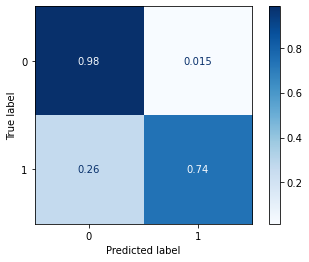

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, grid_svc.predict(X_test),
                                        display_labels=grid_svc.classes_, cmap='Blues',
                                       normalize='true');

## Conclusion

We conducted an analysis of the given dataset and found no missing values or duplicates. Next, we processed the text by lemmatizing the words and removing unnecessary elements. We transformed the reviews into vectors for training the model and making further predictions. Since the dataset had a significant class imbalance, we applied methods such as class weighting and undersampling using the majority class during training. However, models trained on the undersampled dataset yielded poorer results, indicating a lack of sufficient data. The best-performing model was the SVC (Support Vector Classifier) with an F1 score of 0.789.

By constructing a confusion matrix, we can examine the model's performance in detail. It reveals that the model correctly predicts the minority class only in 72% of cases.